In [1]:
from tokeniser import Tokeniser
from load_text import load_prideandprejudice
import tensorflow as tf
import numpy as np
import sys
import os

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-15 01:51:25.912156: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 01:51:25.936664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 01:51:26.388718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorR

# Create tokens

In [16]:
vocab_size = 1000 #Size of the vocabulary
vec_dim = 50
window_size = 4
epochs = 10
text_length = 100000

  0% (0 of 926) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (6 of 926) |                        | Elapsed Time: 0:00:00 ETA:   0:00:17
  1% (12 of 926) |                       | Elapsed Time: 0:00:00 ETA:   0:00:14


Loading tokeniser from 'vocab_1000.json'...


  2% (21 of 926) |                       | Elapsed Time: 0:00:00 ETA:   0:00:12
  3% (30 of 926) |                       | Elapsed Time: 0:00:00 ETA:   0:00:12
  3% (36 of 926) |                       | Elapsed Time: 0:00:00 ETA:   0:00:11
  5% (47 of 926) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:10
  6% (59 of 926) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:09
  7% (71 of 926) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:09
  8% (83 of 926) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:08
 10% (94 of 926) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:08
 11% (106 of 926) |##                    | Elapsed Time: 0:00:00 ETA:   0:00:07
 12% (118 of 926) |##                    | Elapsed Time: 0:00:01 ETA:   0:00:07
 13% (129 of 926) |###                   | Elapsed Time: 0:00:01 ETA:   0:00:07
 15% (141 of 926) |###                   | Elapsed Time: 0:00:01 ETA:   0:00:06
 16% (153 of 926) |###                  

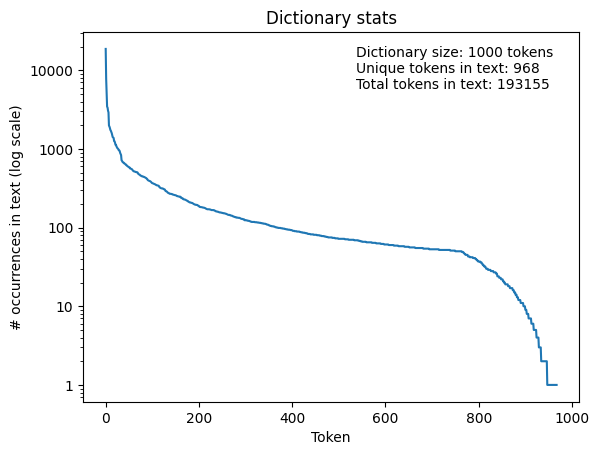

In [17]:
# Load text
filename = f'vocab_{str(vocab_size)}.json'
text = load_prideandprejudice(text_length)

# Check if tokeniser has been saved to disk
if os.path.exists(filename):
    # Load tokeniser from disk
    print("Loading tokeniser from '%s'..." % (filename))
    tokeniser = Tokeniser.load(filename)
else:
    # Create a new tokeniser, train it on the text and save it to disk
    tokeniser = Tokeniser(vocab_size=vocab_size)
    print("Building BPE tokeniser...")
    tokeniser.train(text, verbose=True)
    print("Saving tokeniser to '%s'..." % (filename))
    tokeniser.save(filename)

ids = tokeniser.encode(text, verbose=True)
tokeniser.plot(ids=ids)


# CBOW

### Get Embeddings and save them to file

In [18]:
from tok2vec import tok2Vec
# x = model.get_embeddings()
x, train_info = tok2Vec(vocab_size, ids, window_size, vec_dim, epochs)

Epoch 1/10
 105/5433 [..............................] - ETA: 7s - loss: 6.7666 - accuracy: 0.0911   

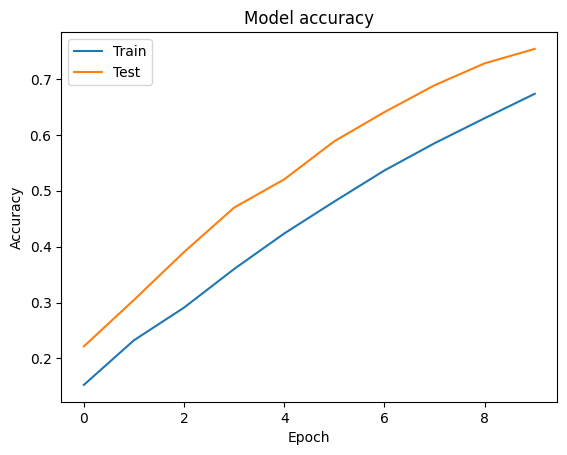

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(train_info.history['accuracy'])
plt.plot(train_info.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

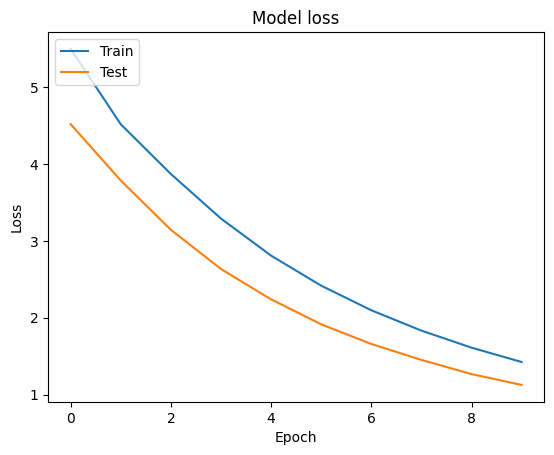

In [ ]:
# plot loss
plt.plot(train_info.history['loss'])
plt.plot(train_info.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from tokeniser import plot_tok2vec
plot_tok2vec(x, tokeniser.word_index)

Plotting word vectors in 2D using t-SNE...


2024-05-15 01:55:08.254966: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Expected begin, end, and strides to be 1D equal size tensors, but got shapes [100], [100], and [100] instead.
2024-05-15 01:55:08.254989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Expected begin, end, and strides to be 1D equal size tensors, but got shapes [100], [100], and [100] instead.


OverflowError: int too big to convert